In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from tqdm import tqdm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Collect Data

In [34]:
tickers_names = {"SHEL": "Shell",
                 "XOM": "ExxonMobil",
                 "BP": "BP",
                 "CVX": "Chevron"}

def FetchStockData(ticker_symbol, company_name):
    ticker = yf.Ticker(ticker_symbol)
    today = datetime.date.today().strftime('%Y-%m-%d')
    data = ticker.history(start="2021-01-01", end=today)
    
    # Reset the index and keep 'Date' as a column
    data.reset_index(inplace=True)
    
    # Ensure the 'Date' column is in the correct format
    if pd.api.types.is_datetime64_any_dtype(data['Date']):
        data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
    
    # Drop unnecessary columns
    data.drop(columns=['Dividends', 'Stock Splits'], inplace=True, errors='ignore')
    
    # Add additional columns for ticker and commodity
    data['ticker'] = ticker_symbol  
    data['company'] = company_name  
    
    # Convert all column names to lowercase for consistency
    data.columns = [col.lower() for col in data.columns]
    
    # Reorder columns to place 'ticker', 'commodity', and 'date' at the beginning
    data = data[['ticker', 'company', 'date'] + [col for col in data.columns if col not in ['ticker', 'company', 'date']]]
    data['date'] = pd.to_datetime(data['date'])

    return data



# 2. Loop over each symbol and append data to a DataFrame
all_data = []
for symbol, name in tickers_names.items():
    all_data.append(FetchStockData(symbol, name))

# Concatenate all the individual datasets into one
stock_data = pd.concat(all_data, ignore_index=True)
stock_data.to_csv('stock_data.csv', index = False)


# Inspect Data

## General

In [35]:
print("Energy Stock Prices Dataset Info:")
print(stock_data.info())

Energy Stock Prices Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4076 entries, 0 to 4075
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ticker   4076 non-null   object        
 1   company  4076 non-null   object        
 2   date     4076 non-null   datetime64[ns]
 3   open     4076 non-null   float64       
 4   high     4076 non-null   float64       
 5   low      4076 non-null   float64       
 6   close    4076 non-null   float64       
 7   volume   4076 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 254.9+ KB
None


In [36]:
print("Energy Stock Prices Dataset Description:")
print(stock_data.describe())

Energy Stock Prices Dataset Description:
                                date         open         high          low  \
count                           4076  4076.000000  4076.000000  4076.000000   
mean   2023-01-11 09:40:48.282630144    75.936090    76.666907    75.186091   
min              2021-01-04 00:00:00    17.060681    17.431918    16.854436   
25%              2022-01-05 00:00:00    35.746208    36.035128    35.464460   
50%              2023-01-11 00:00:00    62.309771    62.718961    61.957709   
75%              2024-01-18 00:00:00   107.572967   108.851396   106.685272   
max              2025-01-23 00:00:00   171.284651   173.628003   170.424196   
std                              NaN    43.996659    44.421358    43.535378   

             close        volume  
count  4076.000000  4.076000e+03  
mean     75.938850  1.145179e+07  
min      17.118431  7.529140e+05  
25%      35.671236  5.903550e+06  
50%      62.382904  9.060950e+06  
75%     107.651564  1.467655e+07  
ma

In [37]:
print("The Number of Instances for Each Company:")
print(stock_data['company'].value_counts())

The Number of Instances for Each Company:
company
Shell         1019
ExxonMobil    1019
BP            1019
Chevron       1019
Name: count, dtype: int64


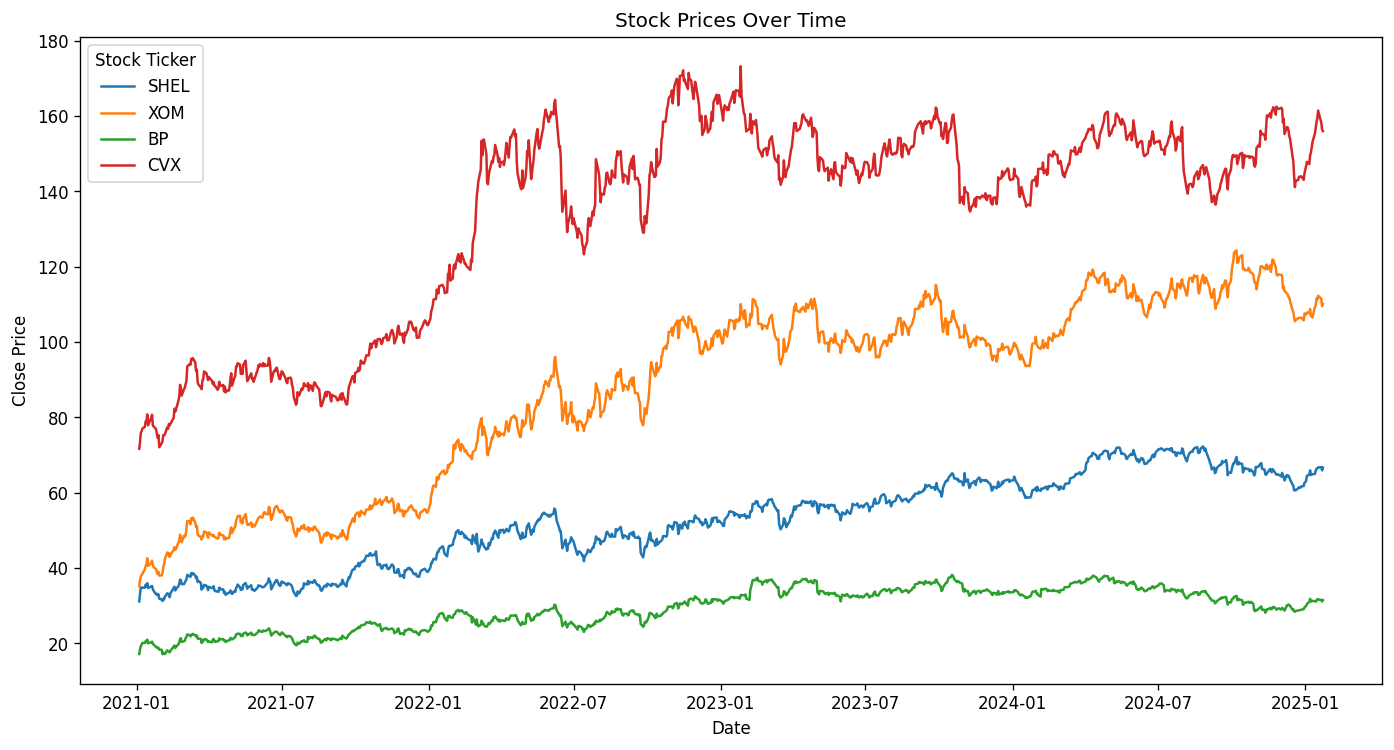

In [38]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data, x='date', y='close', hue='ticker')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title='Stock Ticker')
plt.show()

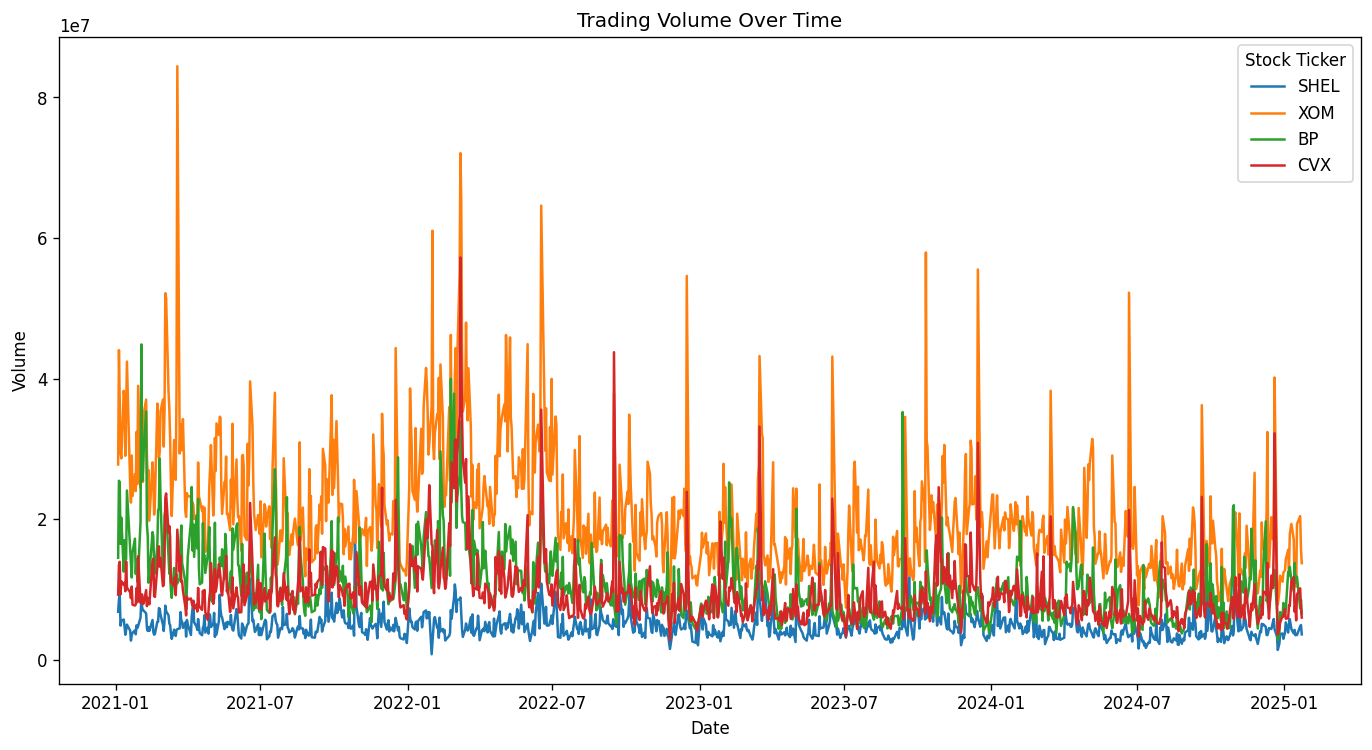

In [39]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data, x='date', y='volume', hue='ticker')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(title='Stock Ticker')
plt.show()

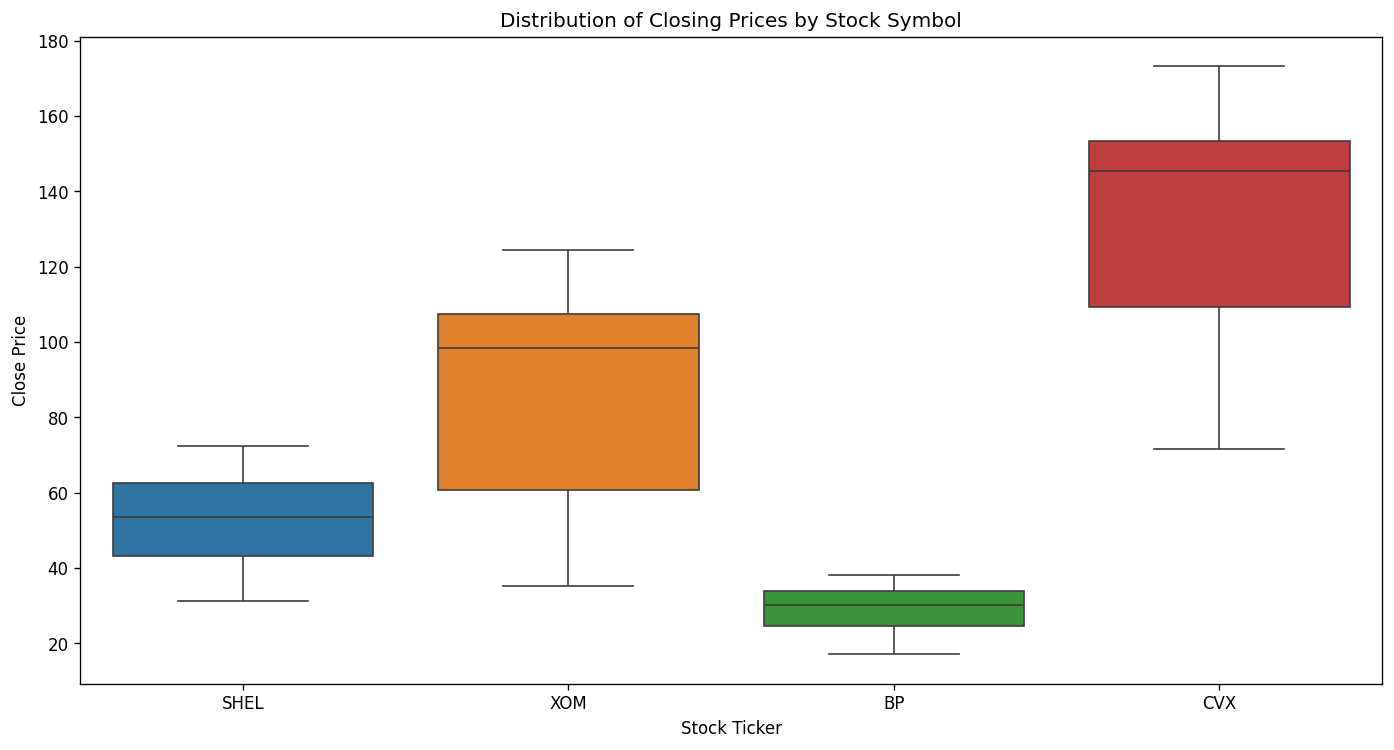

In [40]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=stock_data, x='ticker', y='close', hue='ticker')
plt.title('Distribution of Closing Prices by Stock Symbol')
plt.xlabel('Stock Ticker')
plt.ylabel('Close Price')
plt.show()

In [41]:
pivot_table = stock_data.pivot(index='date', columns='ticker', values='close')
pivot_table

ticker,BP,CVX,SHEL,XOM
date,,,,
2021-01-04,17.184423,71.667786,31.140995,35.163223
2021-01-05,18.463152,73.605202,33.284481,36.857830
2021-01-06,19.312889,75.974113,34.822956,37.798340
2021-01-07,19.725378,76.329453,34.866169,38.094902
2021-01-08,20.129622,77.057037,34.779739,38.518555
...,...,...,...,...
2025-01-16,31.780001,159.380005,66.449997,111.320000
2025-01-17,31.690001,161.470001,66.720001,112.320000
2025-01-21,31.520000,158.240005,66.769997,111.470001


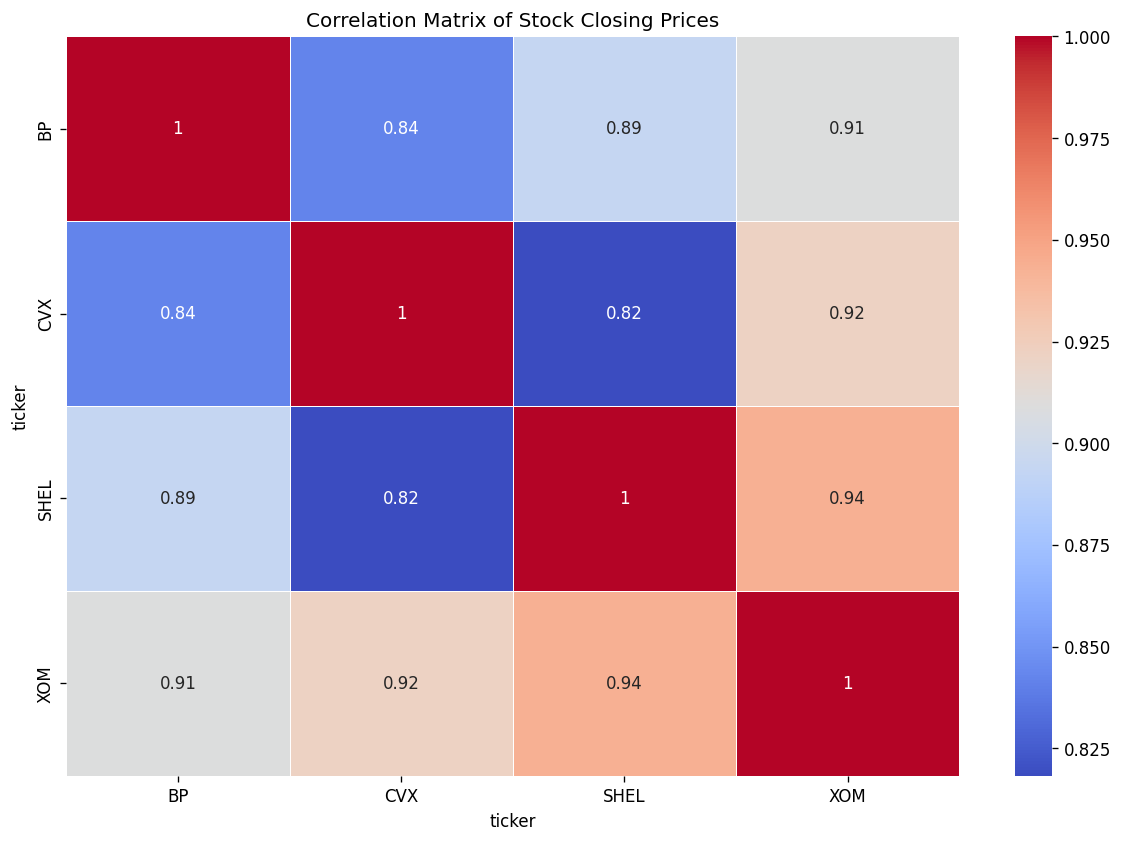

In [42]:
correlation_matrix = pivot_table.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Stock Closing Prices')
plt.show()

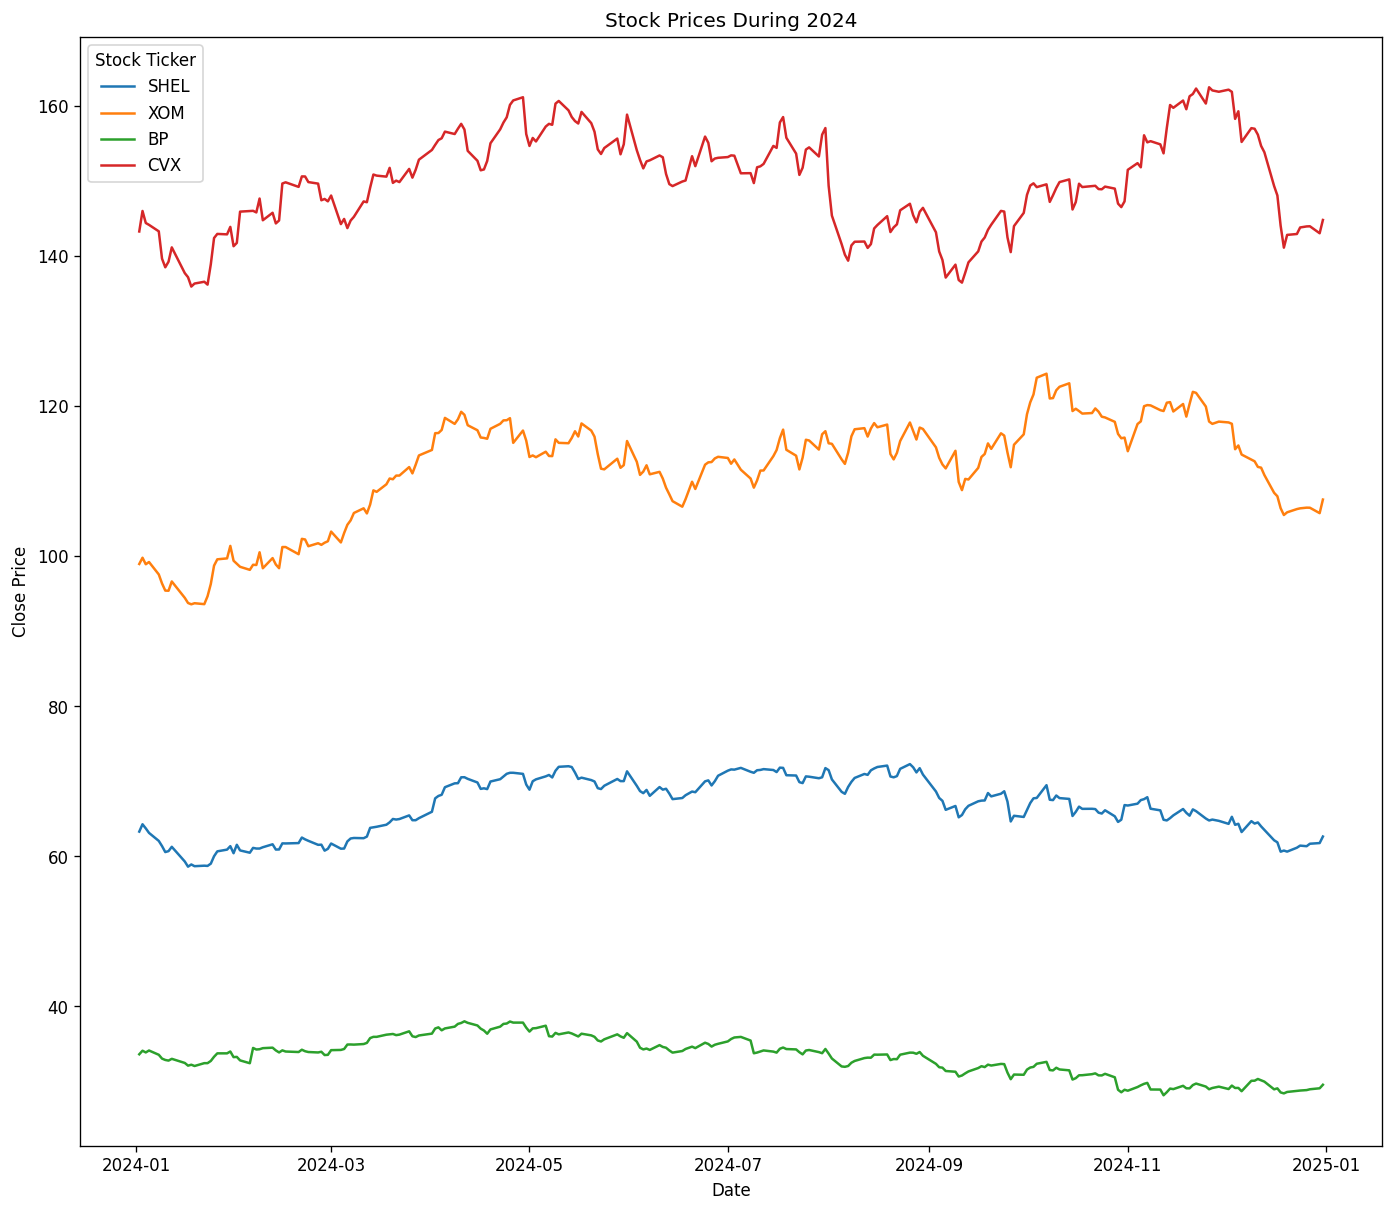

In [43]:
stock_data_2024 = stock_data[(stock_data['date'] >= '2024-01-01') & (stock_data['date'] <= '2024-12-31')]

plt.figure(figsize= (14, 12))
sns.lineplot(data = stock_data_2024, x = 'date', y = 'close', hue = 'ticker')
plt.title('Stock Prices During 2024')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title = 'Stock Ticker')
plt.show()

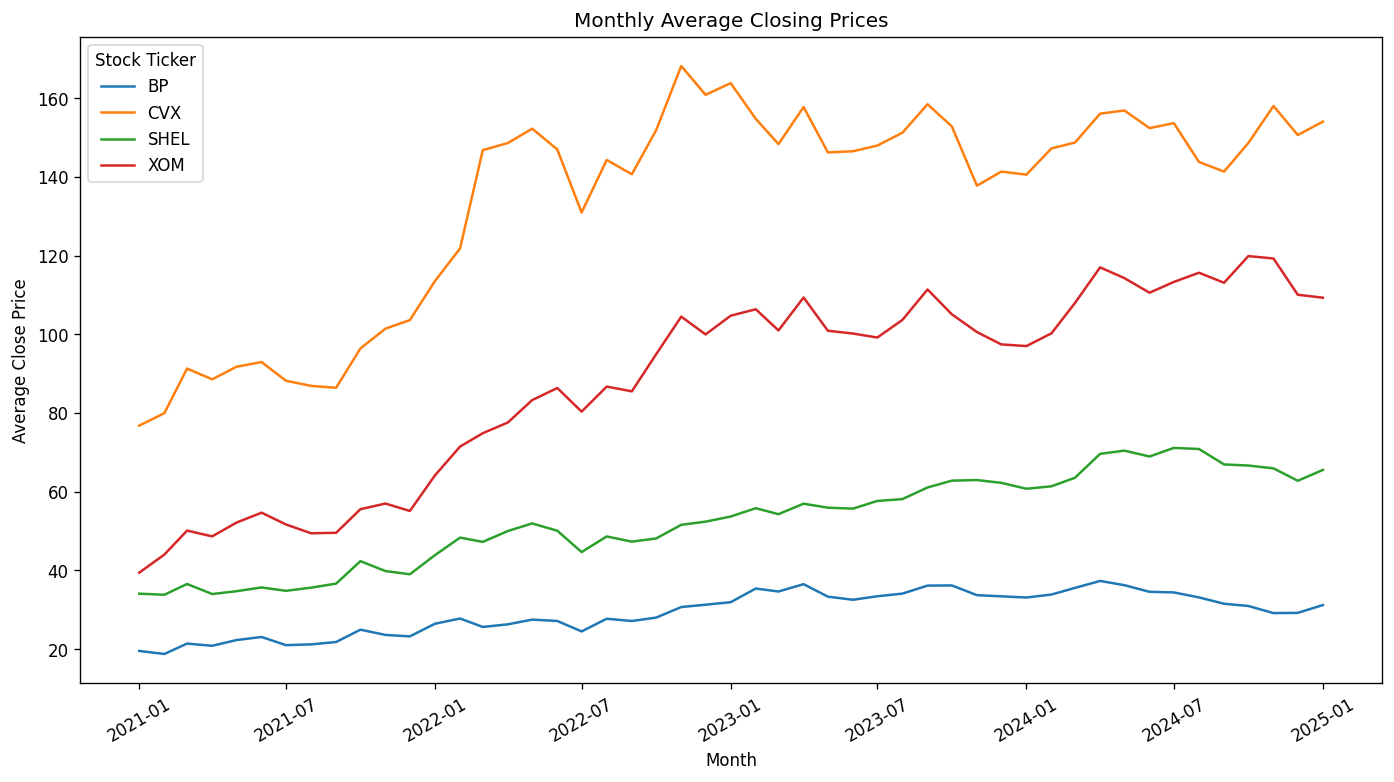

In [44]:
stock_data['month'] = stock_data['date'].dt.to_period('M').dt.to_timestamp()
monthly_avg_prices = stock_data.groupby(['month', 'ticker']).mean(numeric_only=True).reset_index()

plt.figure(figsize = (14, 7))
sns.lineplot(data = monthly_avg_prices, x = 'month', y = 'close', hue = 'ticker')
plt.title('Monthly Average Closing Prices')
plt.xlabel('Month')
plt.ylabel('Average Close Price')
plt.xticks(rotation = 30)
plt.legend(title = 'Stock Ticker')
plt.show()

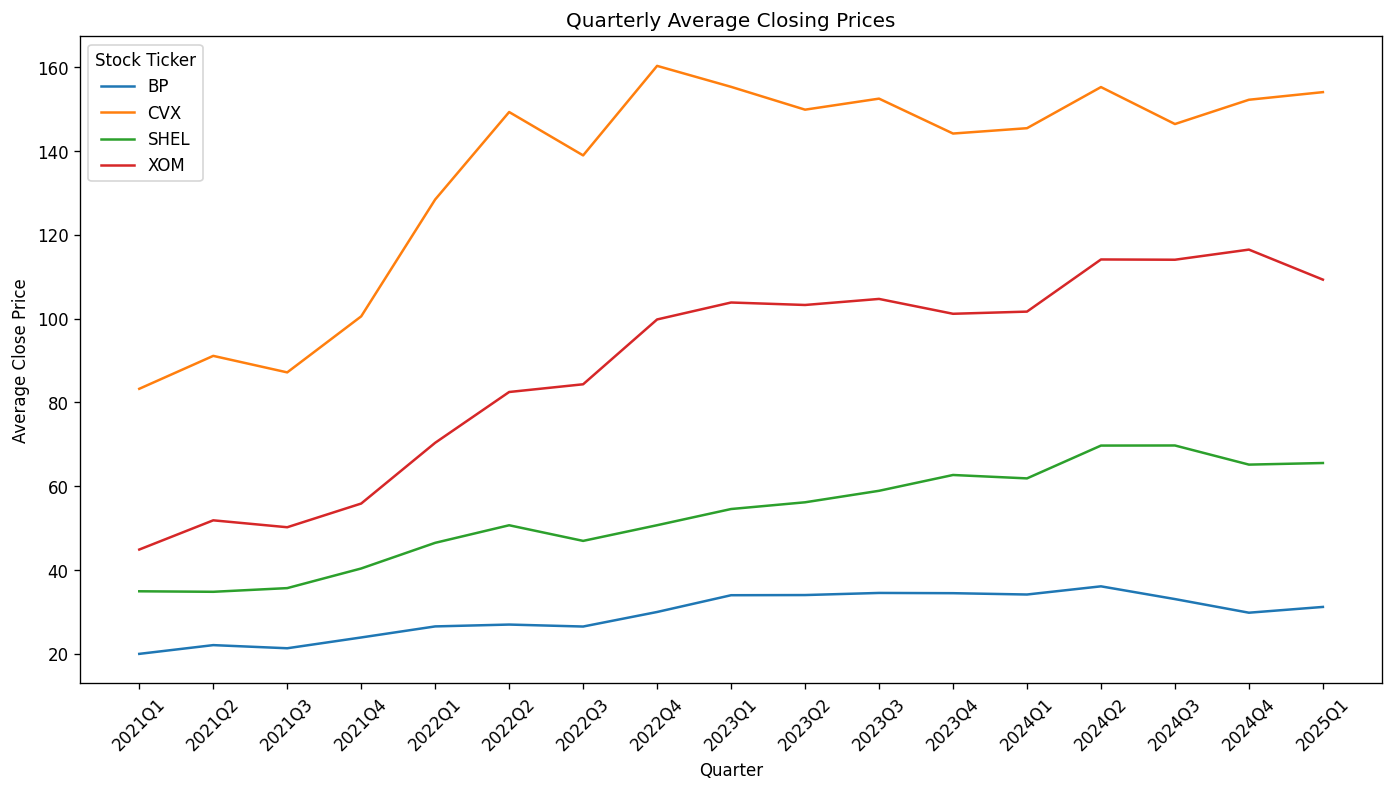

In [45]:
stock_data['quarter'] = stock_data['date'].dt.to_period('Q')
quarterly_avg_prices = stock_data.groupby(['quarter', 'ticker']).mean(numeric_only=True).reset_index()
quarterly_avg_prices['quarter'] = quarterly_avg_prices['quarter'].astype(str)

plt.figure(figsize = (14, 7))
sns.lineplot(data = quarterly_avg_prices, x = 'quarter', y = 'close', hue = 'ticker')
plt.title('Quarterly Average Closing Prices')
plt.xlabel('Quarter')
plt.ylabel('Average Close Price')
plt.xticks(rotation = 45)
plt.legend(title = 'Stock Ticker')
plt.show()

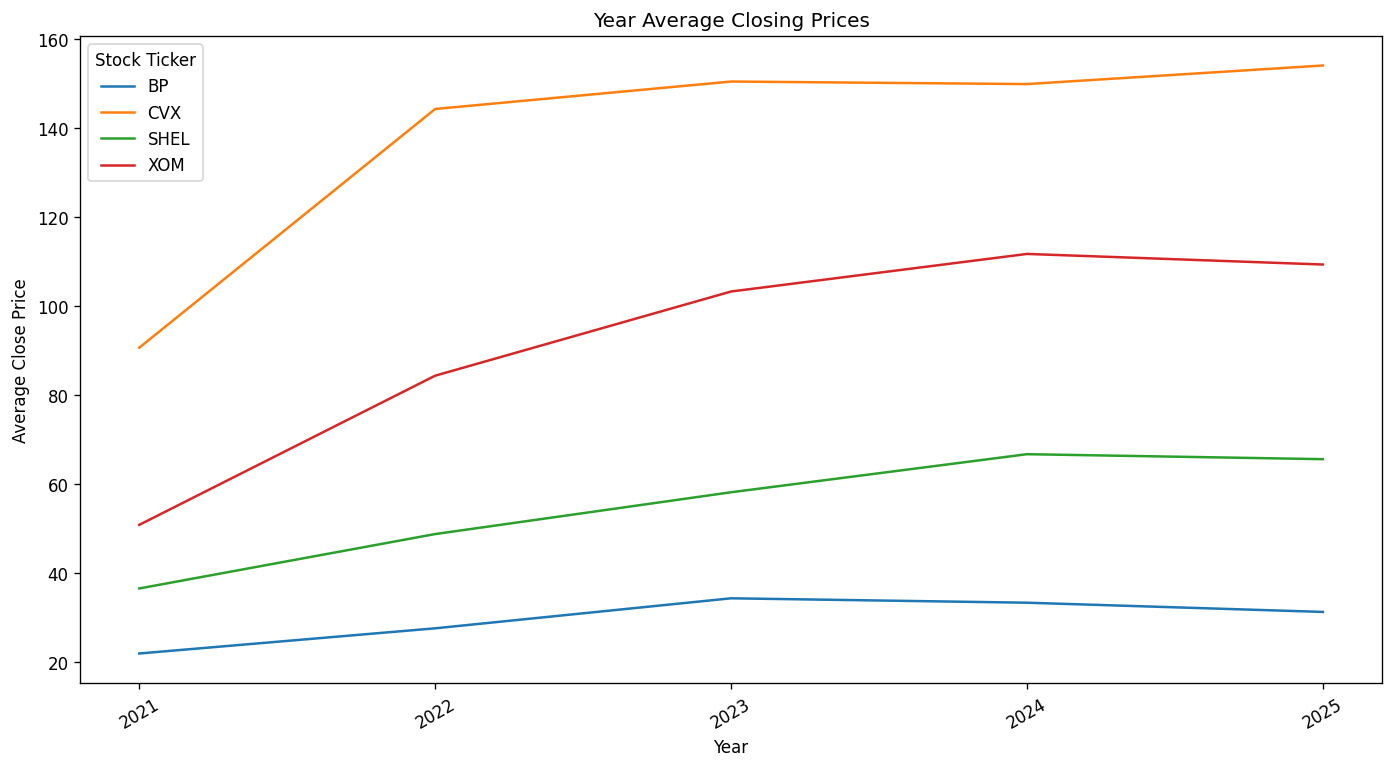

In [46]:
stock_data['year'] = stock_data['date'].dt.year
yearly_avg_prices = stock_data.groupby(['year', 'ticker']).mean(numeric_only=True).reset_index()
yearly_avg_prices['year'] = yearly_avg_prices['year'].astype(int)

plt.figure(figsize = (14, 7))
sns.lineplot(data = yearly_avg_prices, x = 'year', y = 'close', hue = 'ticker')
plt.title('Year Average Closing Prices')
plt.xlabel('Year')
plt.ylabel('Average Close Price')
plt.xticks(ticks=yearly_avg_prices['year'].unique(), rotation=30)
plt.legend(title = 'Stock Ticker')
plt.show()

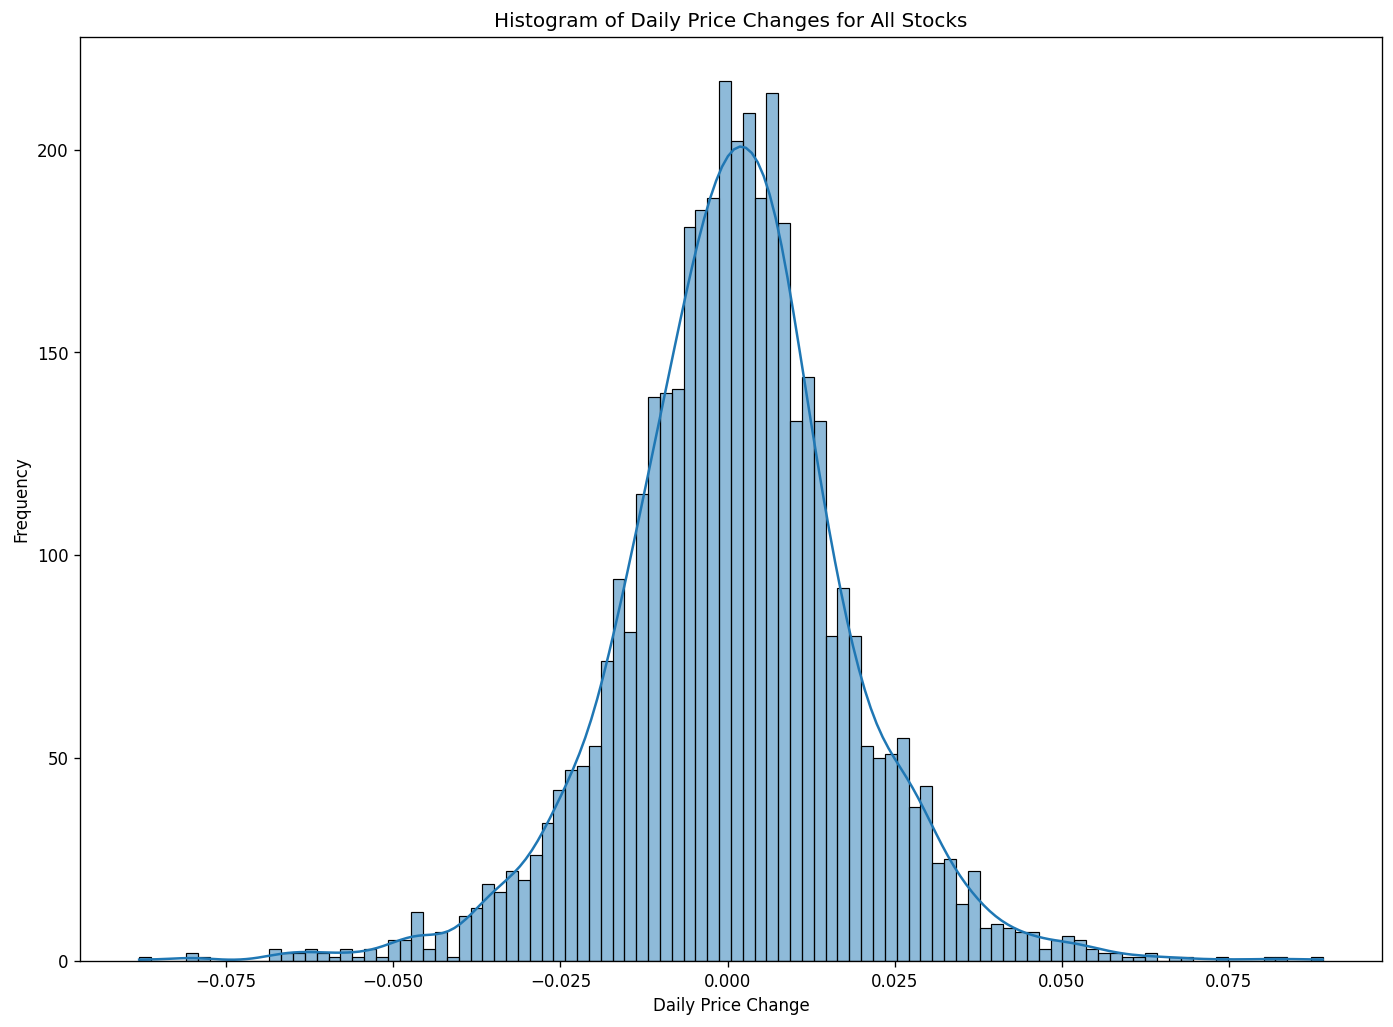

In [47]:
stock_data['price_change'] = stock_data.groupby('ticker')['close'].pct_change() # percentage change

plt.figure(figsize = (14, 10))

sns.histplot(stock_data['price_change'].dropna(), bins = 100, kde = True)
plt.title('Histogram of Daily Price Changes for All Stocks')
plt.xlabel('Daily Price Change')
plt.ylabel('Frequency')
plt.show()

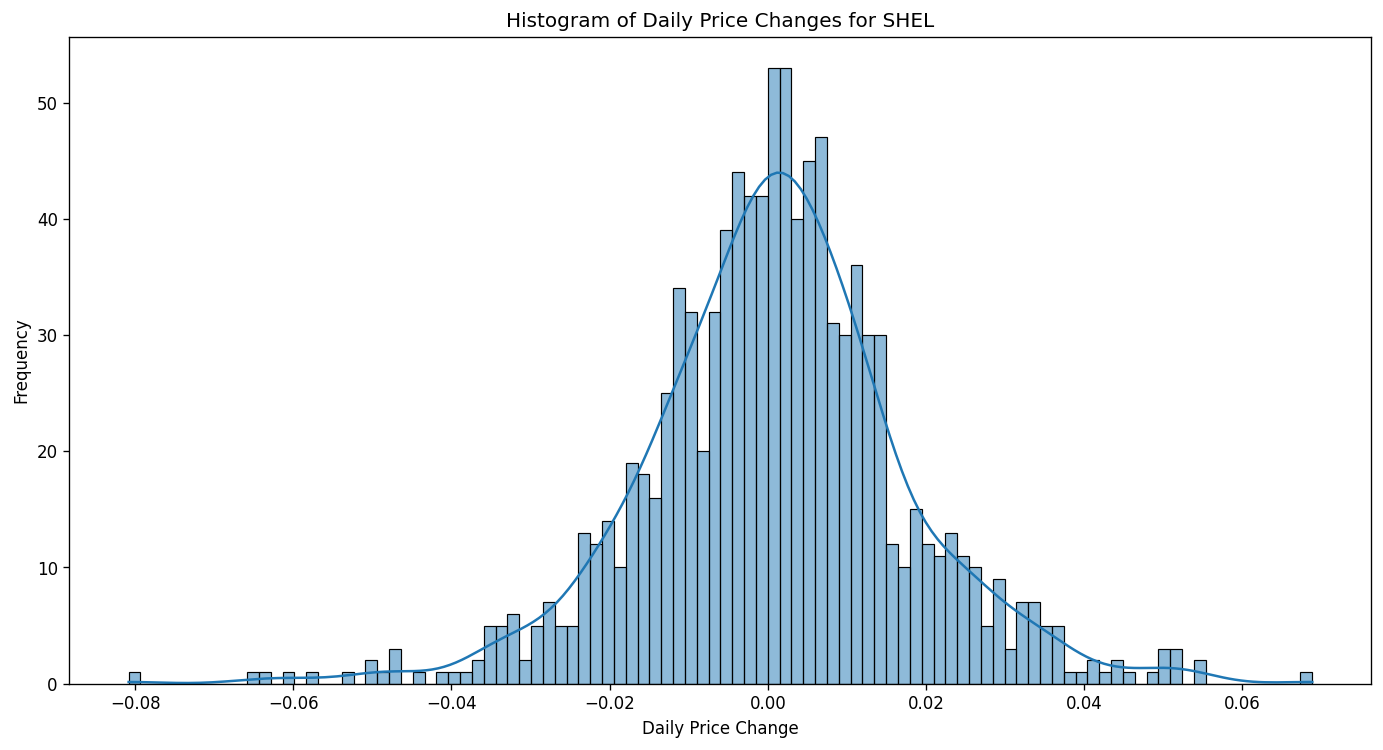

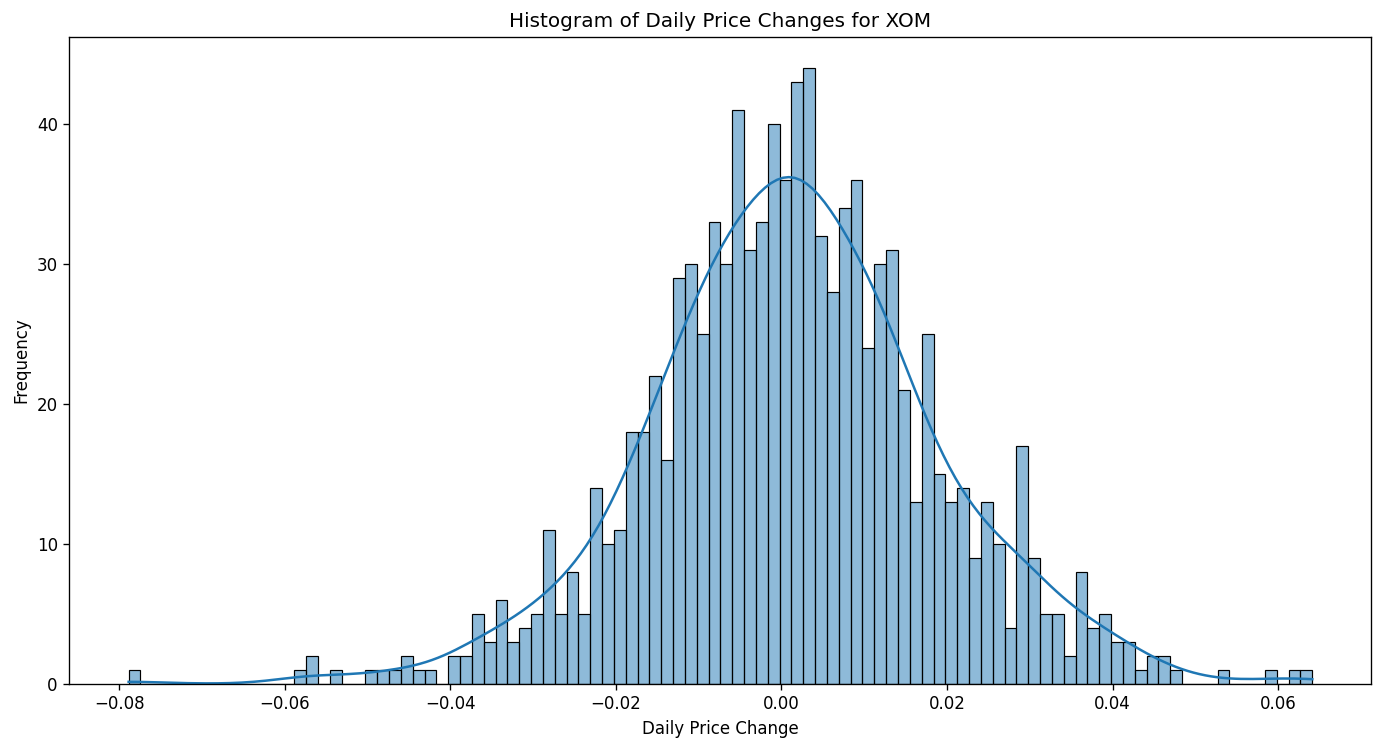

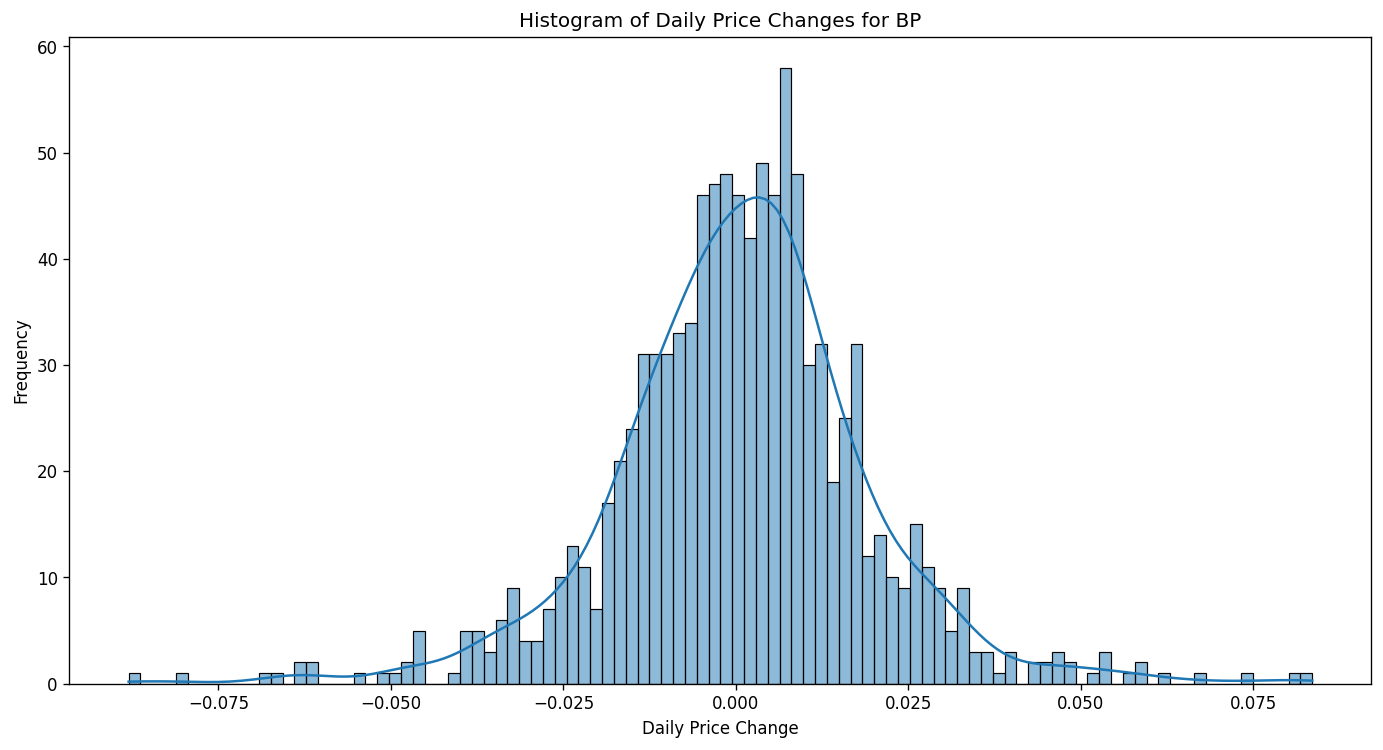

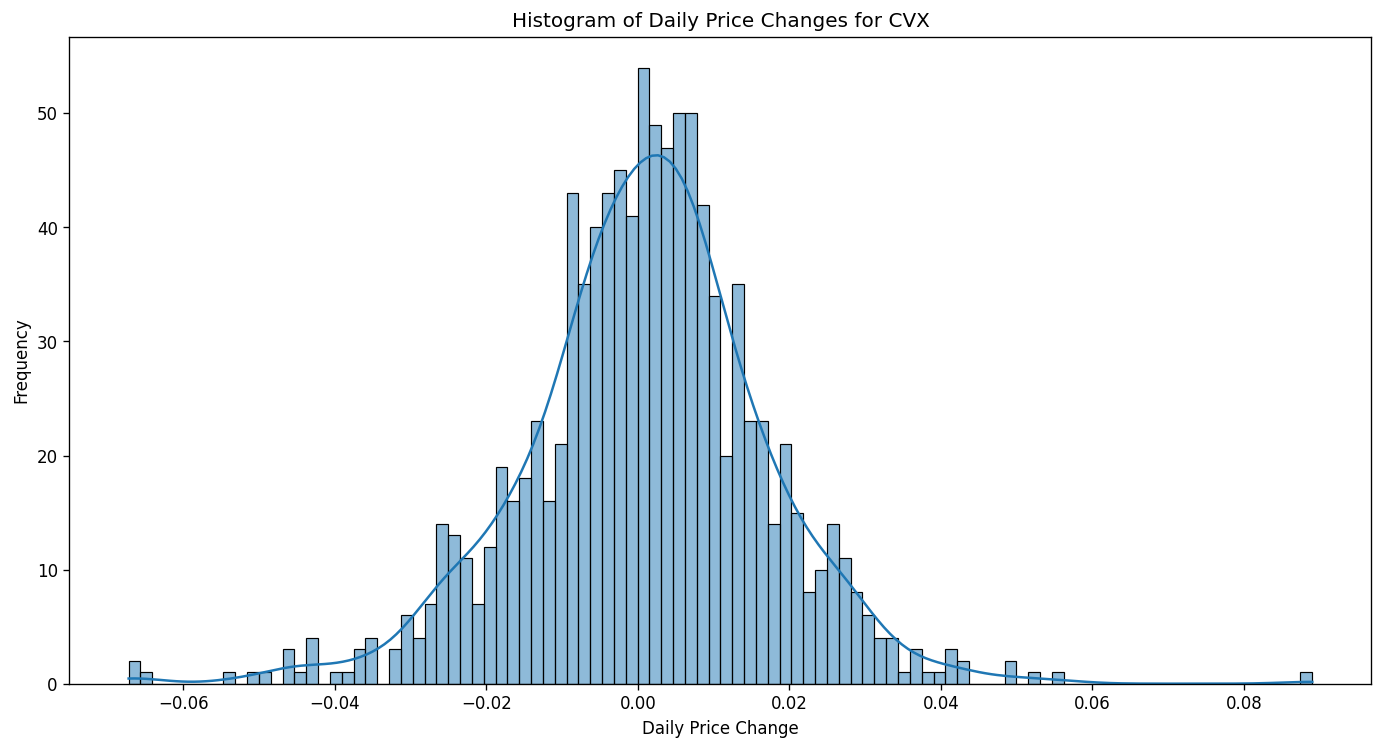

In [48]:
unique_tickers = stock_data['ticker'].unique()

for t in unique_tickers:
    plt.figure(figsize = (14, 7))
    sns.histplot(stock_data[stock_data['ticker'] == t]['price_change'].dropna(), bins = 100, kde = True)
    plt.title(f"Histogram of Daily Price Changes for {t}")
    plt.xlabel('Daily Price Change')
    plt.ylabel('Frequency')
    plt.show()

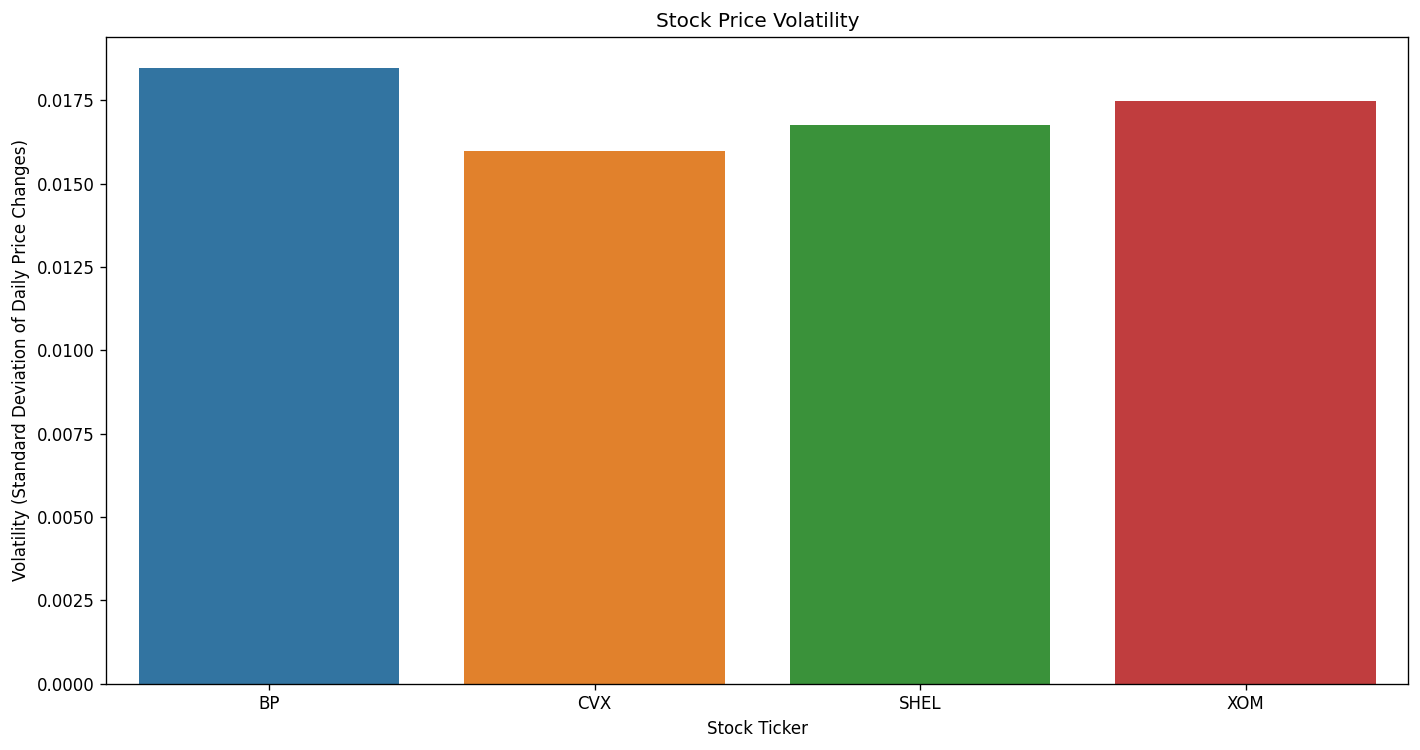

In [49]:
volatility = stock_data.groupby('ticker')['price_change'].std().reset_index()
volatility.columns = ['ticker', 'volatility']

plt.figure(figsize = (14, 7))
sns.barplot(data = volatility, x = 'ticker', y = 'volatility', hue = 'ticker')
plt.title('Stock Price Volatility')
plt.xlabel('Stock Ticker')
plt.ylabel('Volatility (Standard Deviation of Daily Price Changes)')
plt.show()

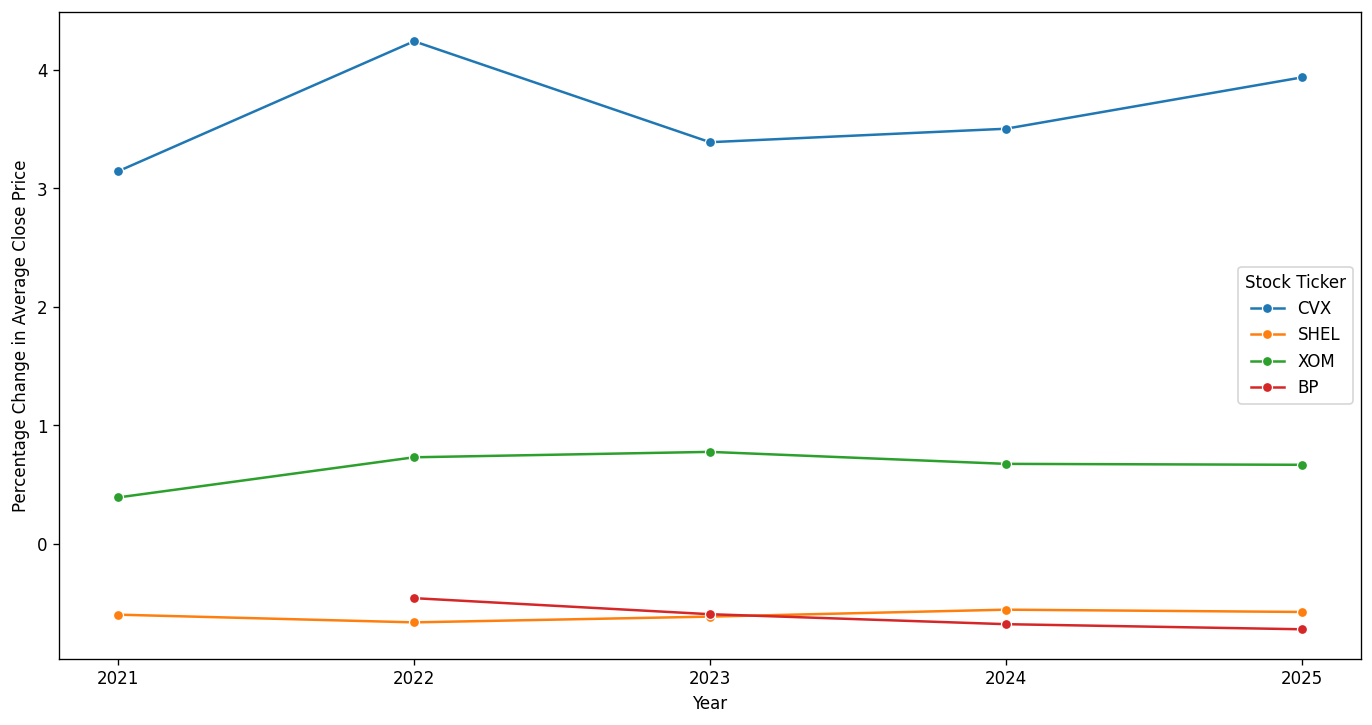

In [50]:
yearly_price_change = stock_data.groupby(['year', 'ticker'])['close'].mean().pct_change().reset_index()
yearly_price_change = yearly_price_change.dropna()

plt.figure(figsize=(14, 7))
sns.lineplot(data = yearly_price_change, x = 'year', y = 'close', hue = 'ticker', marker='o')
plt.xlabel('Year')
plt.ylabel('Percentage Change in Average Close Price')
plt.xticks(ticks=yearly_price_change['year'].unique()) # Display integer instead of decimal number as year
plt.legend(title = 'Stock Ticker')
plt.show()

## Shell

In [51]:
shell_stock = stock_data[stock_data['ticker'] == 'SHEL']
shell_stock.set_index('date', inplace = True)

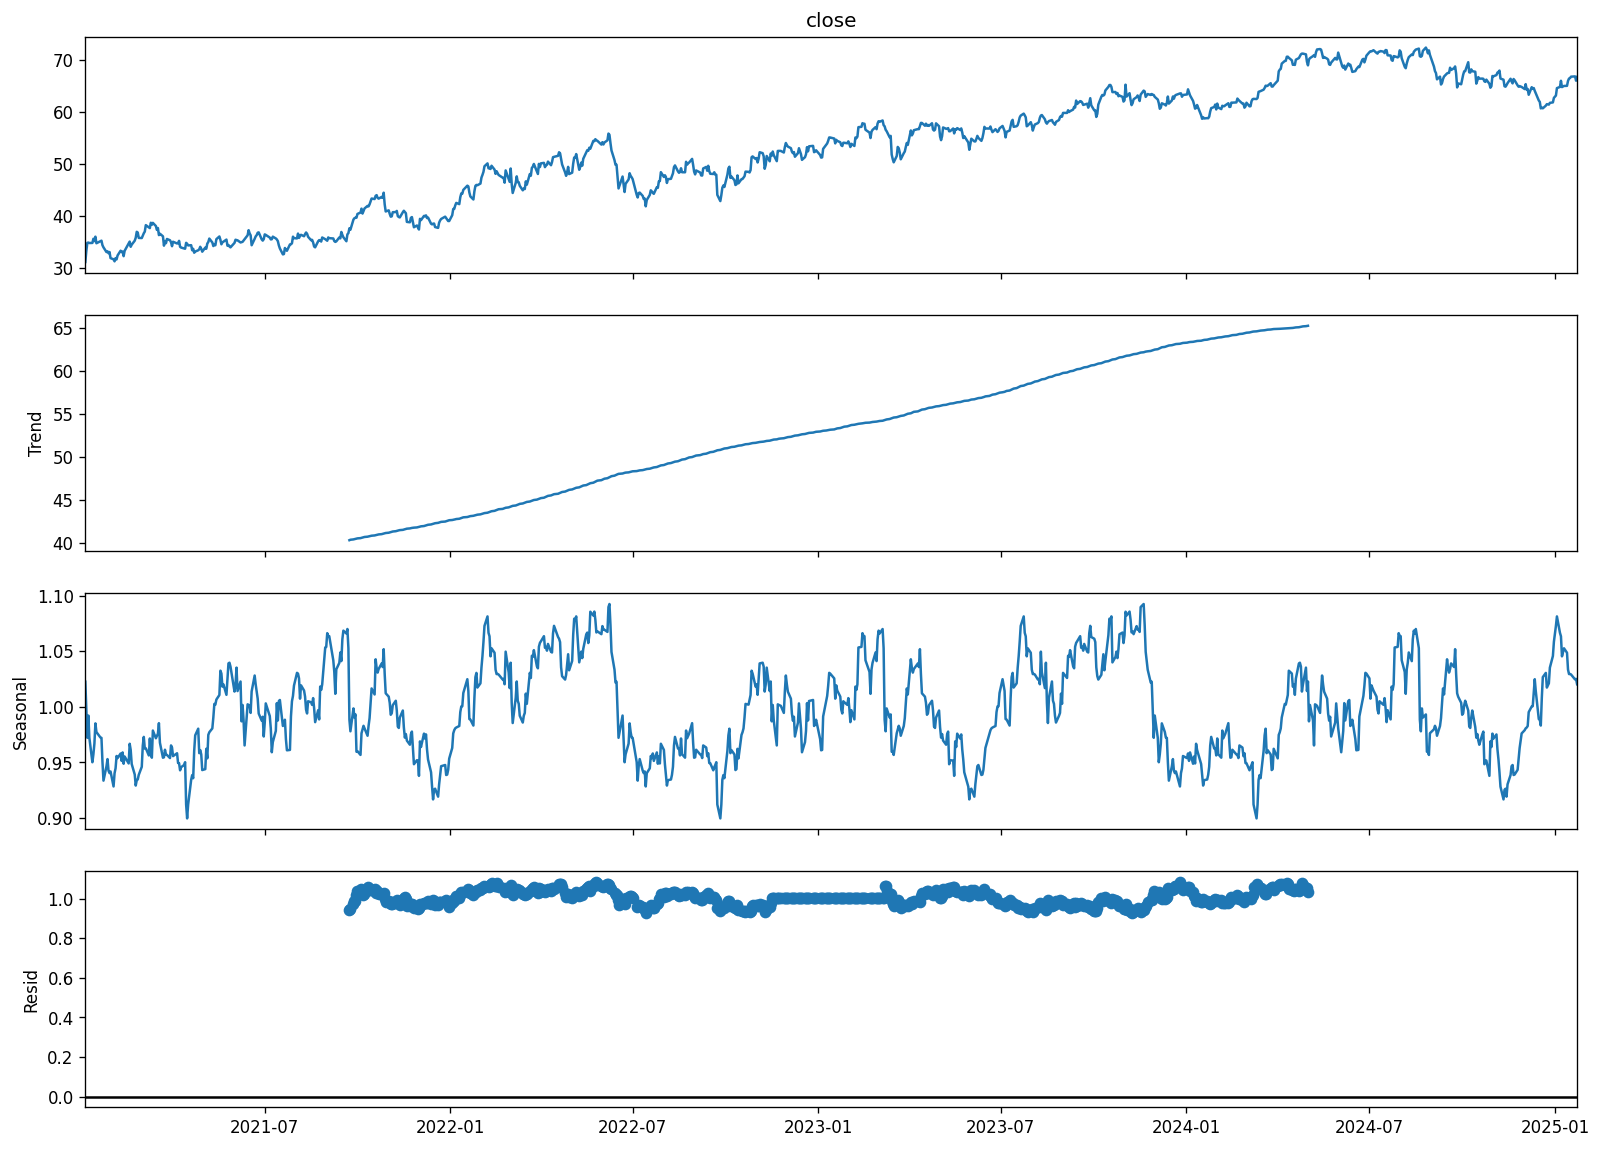

In [52]:
decomposition = seasonal_decompose(shell_stock['close'], model = 'multiplicative', period = 365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

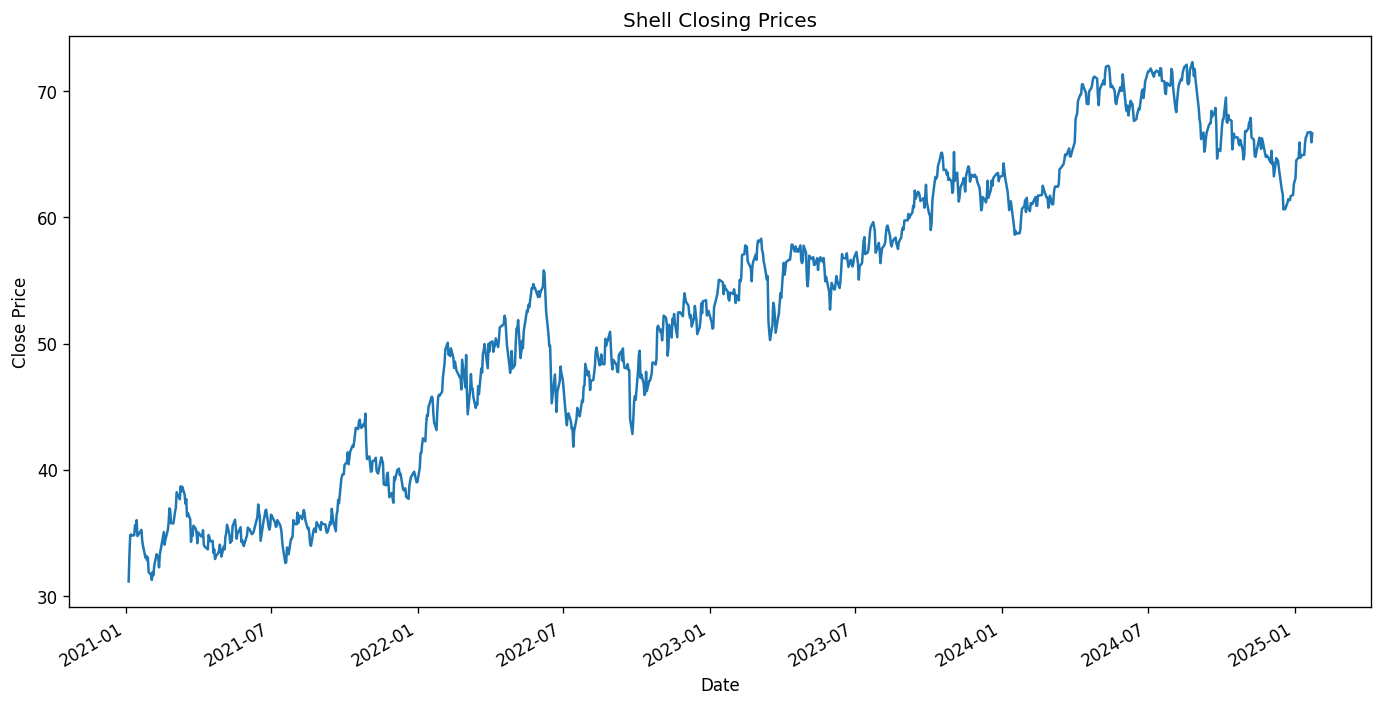

In [53]:
plt.figure(figsize=(14, 7))
shell_stock['close'].plot()
plt.title("Shell Closing Prices")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\Ying\AppData\Local\Temp\ipykernel_27380\1717016293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shell_stock['rolling_mean'] = shell_stock['close'].rolling(window = 30).mean()


<Figure size 1680x840 with 0 Axes>

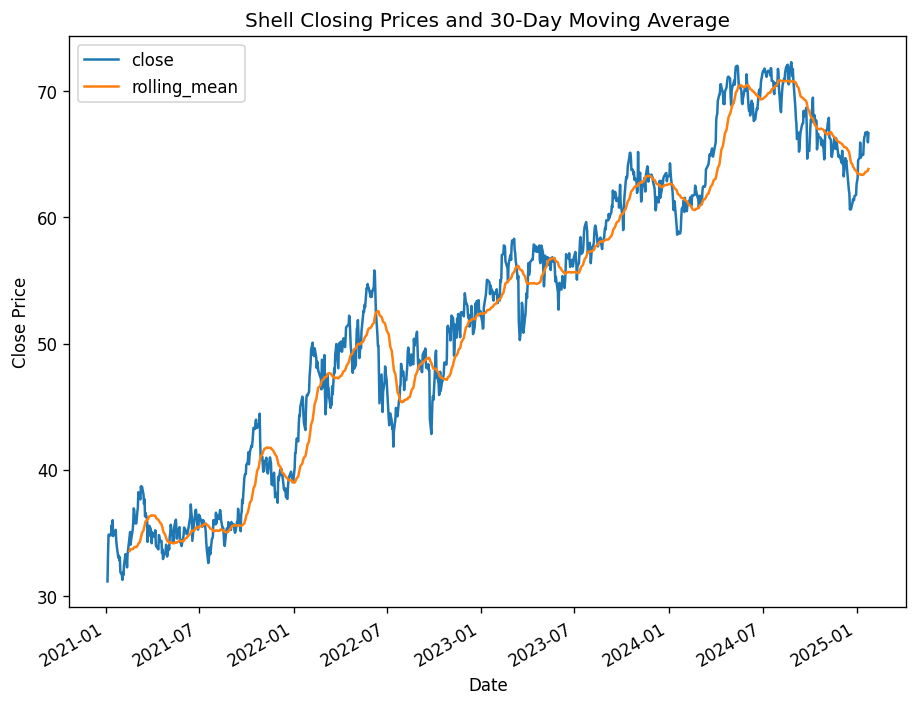

In [54]:
shell_stock['rolling_mean'] = shell_stock['close'].rolling(window = 30).mean()

plt.figure(figsize=(14, 7))
shell_stock[['close', 'rolling_mean']].plot()
plt.title('Shell Closing Prices and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

## Chevron

In [55]:
cvx_stock = stock_data[stock_data['ticker'] == 'CVX']
cvx_stock.set_index('date', inplace = True)

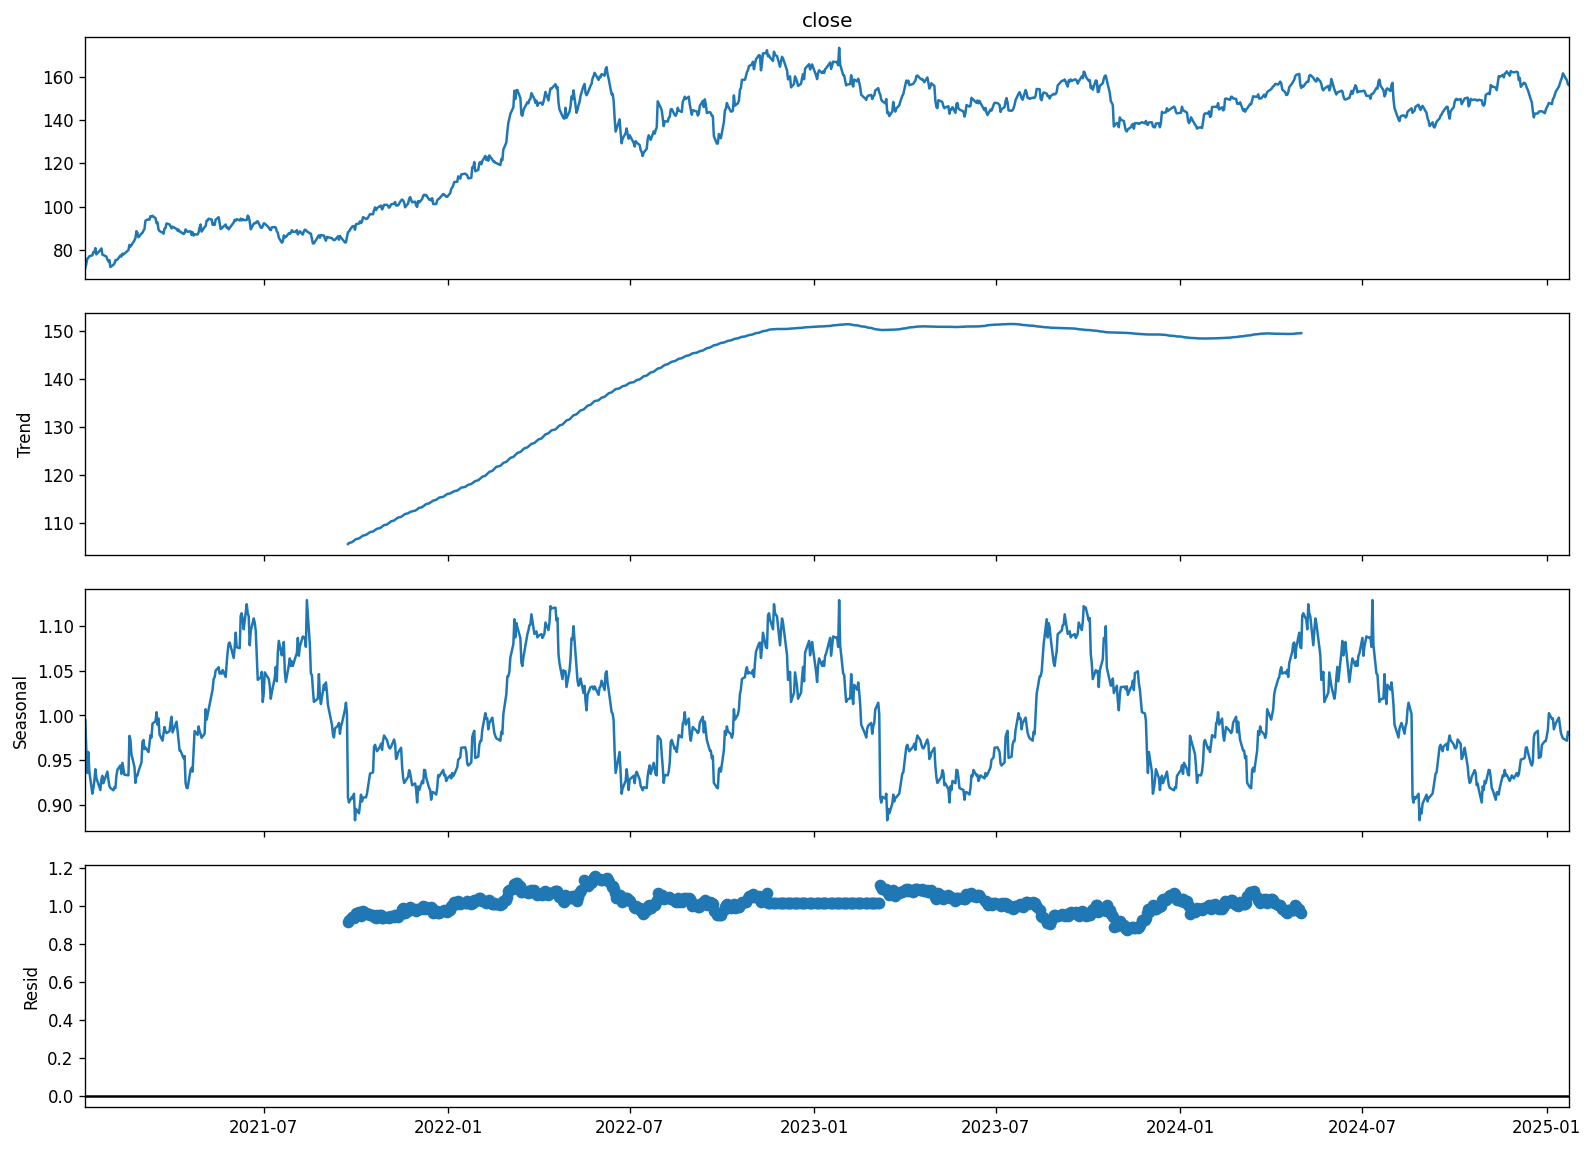

In [56]:
decomposition = seasonal_decompose(cvx_stock['close'], model = 'multiplicative', period = 365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

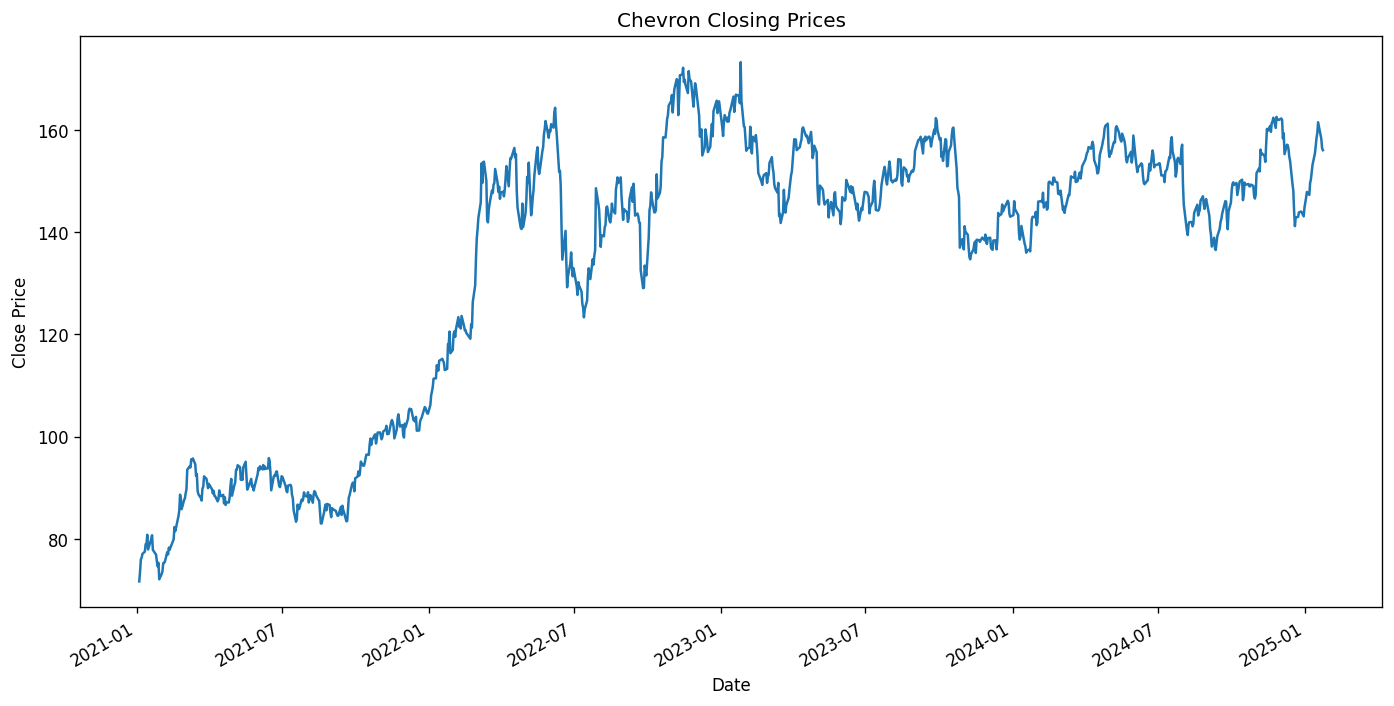

In [57]:
plt.figure(figsize = (14, 7))
cvx_stock['close'].plot()
plt.title('Chevron Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\Ying\AppData\Local\Temp\ipykernel_27380\1352409153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvx_stock['rolling_mean'] = cvx_stock['close'].rolling(window = 30).mean()


<Figure size 1680x840 with 0 Axes>

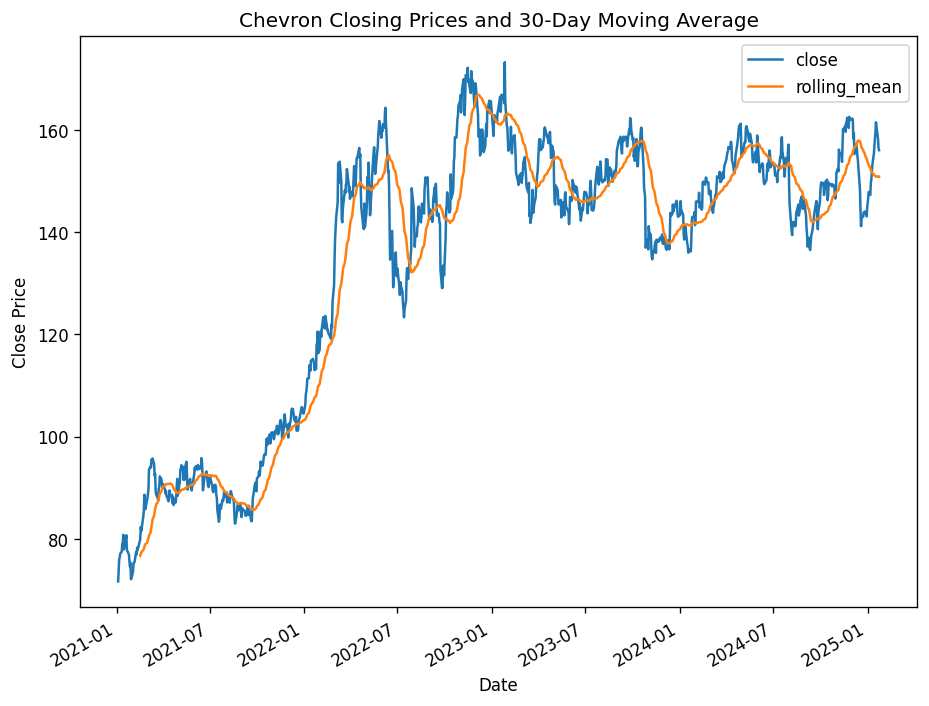

In [58]:
cvx_stock['rolling_mean'] = cvx_stock['close'].rolling(window = 30).mean()

plt.figure(figsize = (14, 7))
cvx_stock[['close', 'rolling_mean']].plot()
plt.title('Chevron Closing Prices and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Prediction

In [59]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
# Requirements for using ARIMA: https://analyticsindiamag.com/ai-trends/5-conditions-when-the-arima-model-should-be-avoided/
# Choose parameters: https://analyticsindiamag.com/ai-trends/quick-way-to-find-p-d-and-q-values-for-arima/


In [79]:
def find_d(data, value_col, max_diff = 5):
    """
    Automatically determine the number of differencing (d) required 
    to make the series stationary using the ADF test.

    Parameters:
    - data: DataFrame containing the time series data.
    - value_col: Column name of the series to difference.
    - max_diff: Maximum number of differencing steps to prevent infinite loops.

    Returns:
    - d: Number of differencing steps applied.
    """
    d = 0
    differenced_data = data[value_col]

    while d < max_diff:
        result = adfuller(differenced_data.dropna())
        adf_stat = result[0]
        p_value = result[1]
        print(f"Test results when d = {d}")
        print(f"ADF Statistic: {adf_stat} ")
        print(f"p-value: {p_value}")
        if p_value < 0.05:
            print(f"Data is stationary after {d} differencing(s).")
            return d
        differenced_data = differenced_data.diff()
        d += 1
    print(f"Reached maximum differencing (d={max_diff}) without achieving stationarity.")
    return d               


def find_dpq(data, value_col):
    """
    Determine the optimal p, d, and q values for ARIMA modeling.

    Parameters:
    - data: DataFrame containing the time series data.
    - value_col: Column name of the series to difference.
    - max_diff: Maximum number of differencing steps to prevent infinite loops.
    """
    # Find d using ADF test
    d = find_d(data, value_col)

    # Apply differencing iteratively based on d
    differenced_data = data[value_col]
    for n in range(d):
        differenced_data = differenced_data.diff().dropna()

    # Plot PACF for p
    print("\nPACF Plot for P (AR term):")
    plot_pacf(differenced_data, lags=20)
    plt.show()

    # Plot ACF for q
    print("\nACF Plot for Q (MA term):")
    plot_acf(differenced_data, lags=20)
    plt.show()

    print(f"Suggested d value: {d}")
    # Return d (and optionally p and q after visual inspection)
    

### SHEL ###
Test results when d = 0
ADF Statistic: -1.5507938349337993 
p-value: 0.5082516411301723
Test results when d = 1
ADF Statistic: -23.820906024404163 
p-value: 0.0
Data is stationary after 1 differencing(s).

PACF Plot for P (AR term):


C:\Users\Ying\AppData\Local\Temp\ipykernel_27380\4139376202.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"### {d['ticker'][0]} ###")


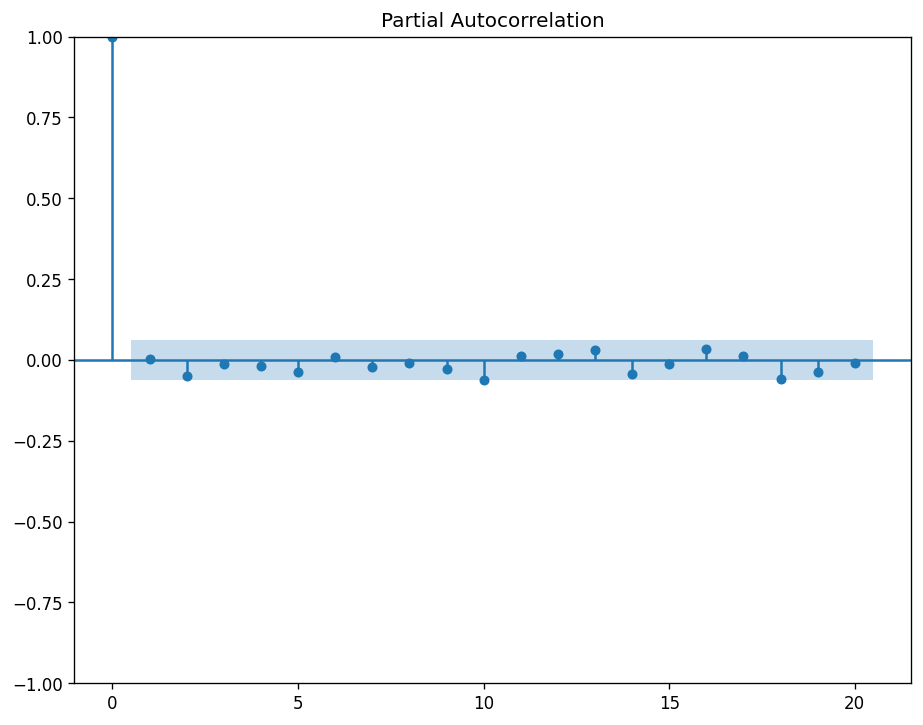


ACF Plot for Q (MA term):


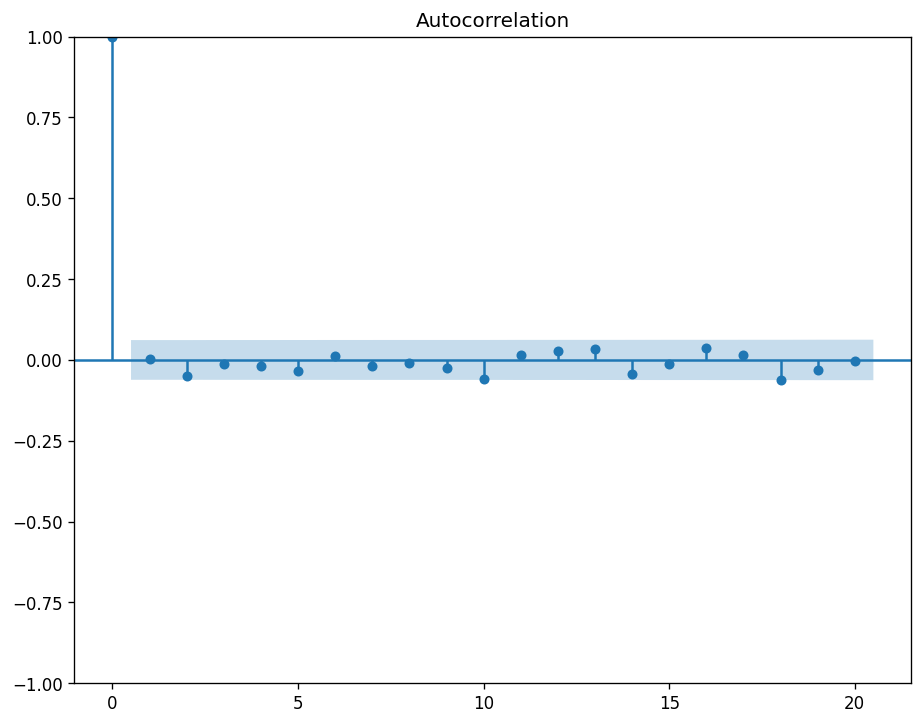

Suggested d value: 1
### CVX ###
Test results when d = 0
ADF Statistic: -2.2012440711809074 
p-value: 0.205794240673068
Test results when d = 1
ADF Statistic: -30.68066725233688 
p-value: 0.0
Data is stationary after 1 differencing(s).

PACF Plot for P (AR term):


C:\Users\Ying\AppData\Local\Temp\ipykernel_27380\4139376202.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"### {d['ticker'][0]} ###")


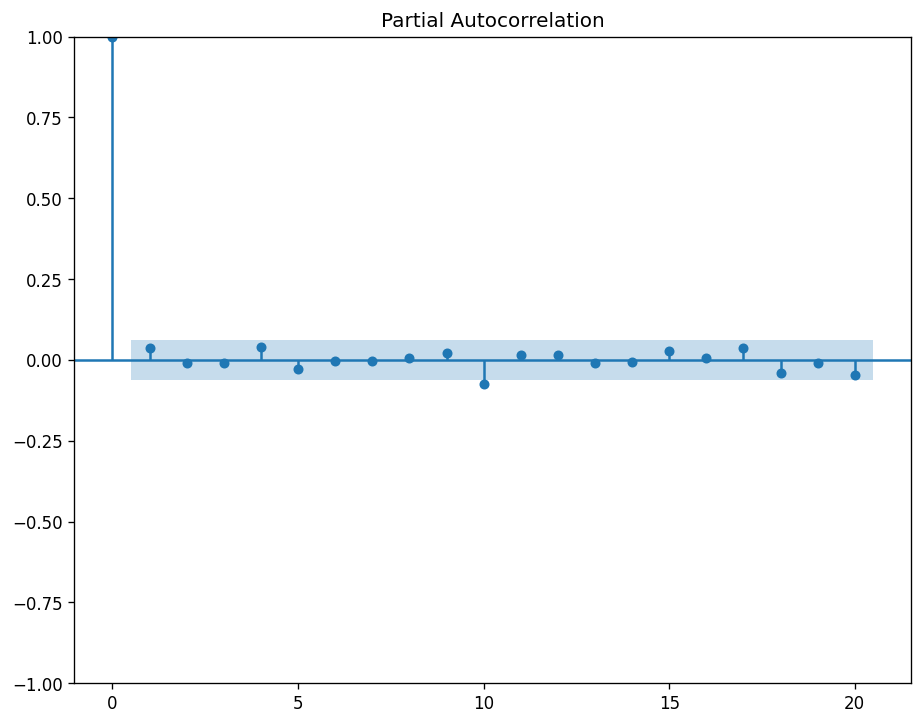


ACF Plot for Q (MA term):


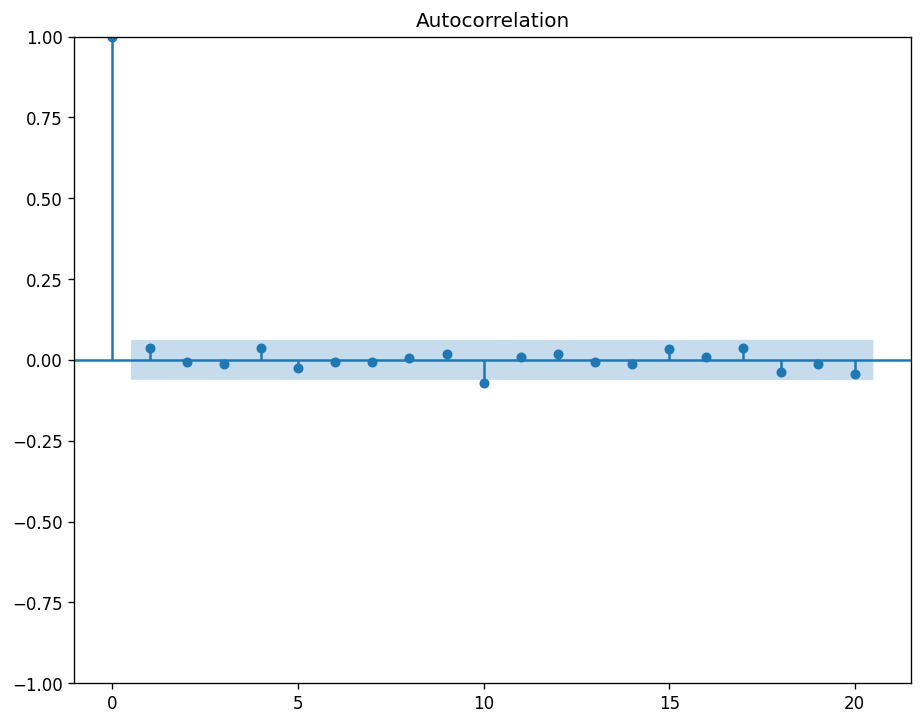

Suggested d value: 1


In [80]:
data_lis = [shell_stock, cvx_stock]
for d in data_lis:
    print(f"### {d['ticker'][0]} ###")
    find_dpq(d, 'close')